In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Modern MLP Models

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.0 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [ ]:
DATA=[]
for i,folder in enumerate(os.listdir('/content/drive/MyDrive/Aseptic Loose Hip Implant X-Ray Data')[1:]):
  for image in os.listdir(f'/content/drive/MyDrive/Aseptic Loose Hip Implant X-Ray Data/{folder}'):
    img=cv2.imread(f'/content/drive/MyDrive/Aseptic Loose Hip Implant X-Ray Data/{folder}/{image}')
    img=cv2.resize(img,(128,128))
    DATA.append((img,i))
DATA=np.array(shuffle(DATA))
Images=np.array([i for i in DATA[:,0]]).reshape((206,128,128,3))
Labels=DATA[:,1]
x_train,x_test,y_train,y_test=Images[:160],Images[160:],Labels[:160],Labels[160:]

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (160, 128, 128, 3) - y_train shape: (160,)
x_test shape: (46, 128, 128, 3) - y_test shape: (46,)


<ipython-input-126-5de8a16bf51f>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DATA=np.array(shuffle(DATA))


Binary

In [ ]:
x_train=x_train.astype(np.float32)
x_test=x_test.astype(np.float32)
y_train=y_train.astype(np.float32)
y_test=y_test.astype(np.float32)

Categorical

In [ ]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [ ]:
np.argmax(y_test,axis=1)

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1])

In [ ]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((160, 128, 128, 3), (160,), (46, 128, 128, 3), (46,))

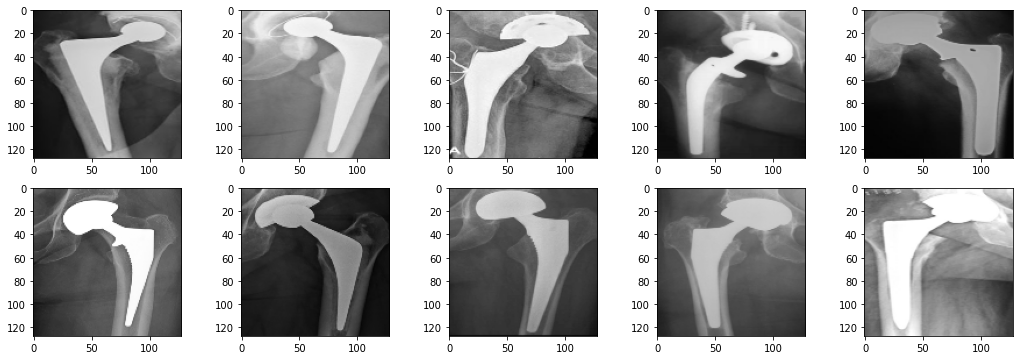

In [ ]:
plt.rcParams['figure.figsize']=(18,6)
plt.subplot(2,5,1)
plt.imshow(x_train[0]/255.0)
plt.subplot(2,5,2)
plt.imshow(x_train[1]/255.0)
plt.subplot(2,5,3)
plt.imshow(x_train[2]/255.0)
plt.subplot(2,5,4)
plt.imshow(x_train[3]/255.0)
plt.subplot(2,5,5)
plt.imshow(x_train[4]/255.0)

plt.subplot(2,5,6)
plt.imshow(x_train[5]/255.0)
plt.subplot(2,5,7)
plt.imshow(x_train[6]/255.0)
plt.subplot(2,5,8)
plt.imshow(x_train[7]/255.0)
plt.subplot(2,5,9)
plt.imshow(x_train[8]/255.0)
plt.subplot(2,5,10)
plt.imshow(x_train[9]/255.0)

plt.show()

In [ ]:
weight_decay = 0.0001
batch_size = 32
num_epochs = 50
dropout_rate = 0.2
image_size = 128
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.
input_shape=(128,128,3)
num_classes=2

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 128 X 128 = 16384
Patch size: 8 X 8 = 64 
Patches per image: 256
Elements per patch (3 channels): 192


In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(input_dim=num_patches, output_dim=embedding_dim)(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(2,activation='sigmoid')(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
def run_experiment(model):
  # Create Adam optimizer with weight decay.
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  # Compile the model.
  model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.Recall(),keras.metrics.Precision()])
  # Create a learning rate scheduler callback.
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
  # Create an early stopping callback.
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
  # Fit the model.
  history = model.fit(x_train,y_train,batch_size=batch_size,epochs=num_epochs,validation_data=(x_test,y_test))
  plt.rcParams['figure.figsize']=(15,5)    # callbacks=[early_stopping, reduce_lr]
  pd.DataFrame(history.history).plot()
  plt.grid()
  plt.gca().set_ylim(0,1)
  plt.show()
  return history

## Mixer MLP

In [ ]:
data_augmentation = keras.Sequential(
    [layers.Normalization(),layers.Resizing(image_size, image_size),layers.RandomFlip("horizontal"),
                      layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],name="data_augmentation")
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

In [ ]:
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)
        self.mlp1 = keras.Sequential(
            [layers.Dense(units=num_patches),tfa.layers.GELU(),layers.Dense(units=num_patches),layers.Dropout(rate=dropout_rate)])
        self.mlp2 = keras.Sequential(
            [layers.Dense(units=num_patches),tfa.layers.GELU(),layers.Dense(units=embedding_dim),layers.Dropout(rate=dropout_rate)])
        self.normalize = layers.LayerNormalization(epsilon=1e-6)
    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

Epoch 1/50
5/5 [==============================] - 5s 437ms/step - loss: 2.9770 - categorical_accuracy: 0.5312 - recall_24: 0.4688 - precision_24: 0.5282 - val_loss: 0.8584 - val_categorical_accuracy: 0.6087 - val_recall_24: 0.5870 - val_precision_24: 0.6429
Epoch 2/50
5/5 [==============================] - 0s 97ms/step - loss: 1.4203 - categorical_accuracy: 0.5500 - recall_24: 0.5750 - precision_24: 0.5257 - val_loss: 0.9303 - val_categorical_accuracy: 0.6304 - val_recall_24: 0.1739 - val_precision_24: 0.6667
Epoch 3/50
5/5 [==============================] - 0s 91ms/step - loss: 1.2021 - categorical_accuracy: 0.5250 - recall_24: 0.6500 - precision_24: 0.5253 - val_loss: 1.6601 - val_categorical_accuracy: 0.4348 - val_recall_24: 0.0000e+00 - val_precision_24: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 90ms/step - loss: 0.9559 - categorical_accuracy: 0.4875 - recall_24: 0.3625 - precision_24: 0.4957 - val_loss: 0.7077 - val_categorical_accuracy: 0.5870 - val_recall_2

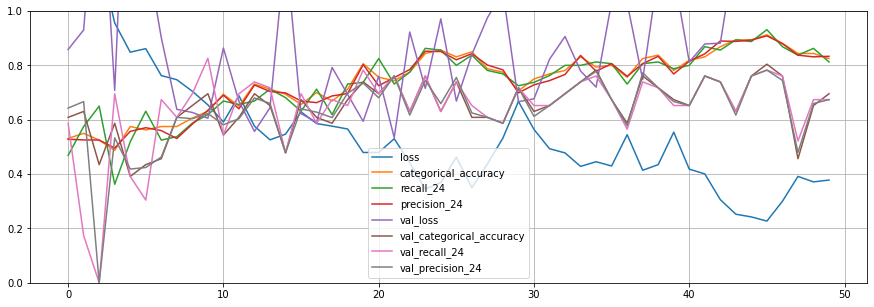

In [ ]:
mlpmixer_blocks = keras.Sequential([MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)])
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)

## FNet Model

In [ ]:
class FNetLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(FNetLayer, self).__init__(*args, **kwargs)
        self.ffn = keras.Sequential(
            [layers.Dense(units=embedding_dim),tfa.layers.GELU(),layers.Dropout(rate=dropout_rate),layers.Dense(units=embedding_dim)])
        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)
    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),dtype=tf.dtypes.float32)
        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedfowrad network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)

Epoch 1/50
5/5 [==============================] - 4s 269ms/step - loss: 0.7817 - categorical_accuracy: 0.4625 - recall_25: 0.4688 - precision_25: 0.4688 - val_loss: 0.6903 - val_categorical_accuracy: 0.6087 - val_recall_25: 0.6087 - val_precision_25: 0.6087
Epoch 2/50
5/5 [==============================] - 0s 90ms/step - loss: 0.7268 - categorical_accuracy: 0.4688 - recall_25: 0.4500 - precision_25: 0.4675 - val_loss: 0.7115 - val_categorical_accuracy: 0.3696 - val_recall_25: 0.4348 - val_precision_25: 0.4000
Epoch 3/50
5/5 [==============================] - 0s 83ms/step - loss: 0.7255 - categorical_accuracy: 0.5625 - recall_25: 0.5688 - precision_25: 0.5617 - val_loss: 0.6852 - val_categorical_accuracy: 0.6087 - val_recall_25: 0.6087 - val_precision_25: 0.6087
Epoch 4/50
5/5 [==============================] - 0s 82ms/step - loss: 0.7210 - categorical_accuracy: 0.4625 - recall_25: 0.4625 - precision_25: 0.4625 - val_loss: 0.7580 - val_categorical_accuracy: 0.3913 - val_recall_25: 0.391

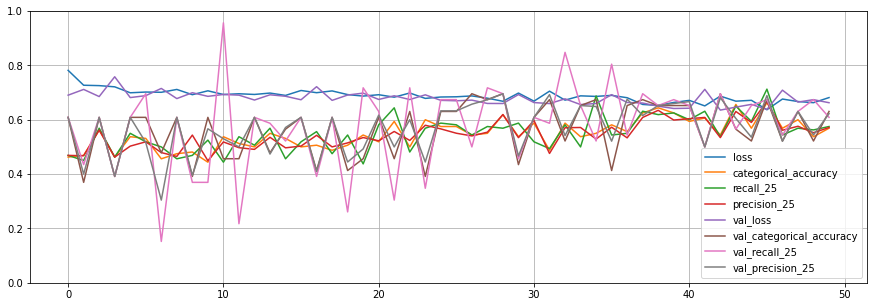

In [ ]:
fnet_blocks = keras.Sequential(
    [FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.001
fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)
history = run_experiment(fnet_classifier)

## Spatial Gating Unit (SGU) Based MLP

In [ ]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(gMLPLayer, self).__init__(*args, **kwargs)
        self.channel_projection1 = keras.Sequential([layers.Dense(units=embedding_dim * 2),tfa.layers.GELU(),
                              layers.Dropout(rate=dropout_rate)])
        self.channel_projection2 = layers.Dense(units=embedding_dim)
        self.spatial_projection = layers.Dense(units=num_patches, bias_initializer="Ones")
        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)
    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected
    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

Epoch 1/50
5/5 [==============================] - 4s 319ms/step - loss: 1.8321 - categorical_accuracy: 0.5063 - recall_26: 0.4688 - precision_26: 0.5000 - val_loss: 0.8607 - val_categorical_accuracy: 0.4565 - val_recall_26: 0.3261 - val_precision_26: 0.4054
Epoch 2/50
5/5 [==============================] - 0s 98ms/step - loss: 0.8329 - categorical_accuracy: 0.4500 - recall_26: 0.6500 - precision_26: 0.4793 - val_loss: 0.8240 - val_categorical_accuracy: 0.3913 - val_recall_26: 0.1522 - val_precision_26: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 90ms/step - loss: 0.7312 - categorical_accuracy: 0.4938 - recall_26: 0.3562 - precision_26: 0.5429 - val_loss: 0.6868 - val_categorical_accuracy: 0.6087 - val_recall_26: 0.8478 - val_precision_26: 0.5132
Epoch 4/50
5/5 [==============================] - 0s 91ms/step - loss: 0.7020 - categorical_accuracy: 0.5125 - recall_26: 0.7937 - precision_26: 0.5121 - val_loss: 0.6873 - val_categorical_accuracy: 0.6522 - val_recall_26: 0.065

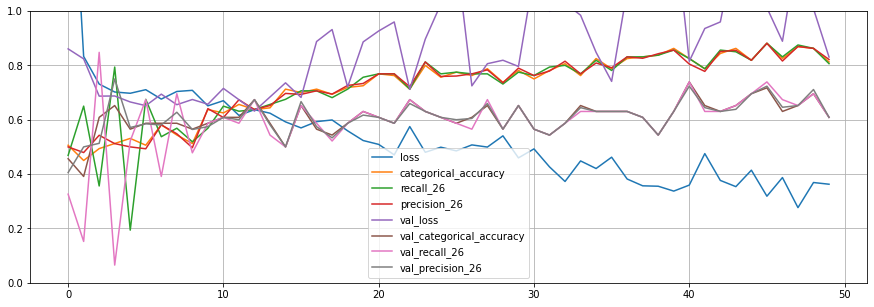

In [ ]:
gmlp_blocks = keras.Sequential([gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)])
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)
history = run_experiment(gmlp_classifier)

## Mixture 1

Epoch 1/50
5/5 [==============================] - 5s 349ms/step - loss: 1.1844 - categorical_accuracy: 0.6562 - recall_40: 0.6313 - precision_40: 0.6235 - val_loss: 1.9029 - val_categorical_accuracy: 0.7174 - val_recall_40: 0.7174 - val_precision_40: 0.7021
Epoch 2/50
5/5 [==============================] - 0s 91ms/step - loss: 0.1167 - categorical_accuracy: 0.9688 - recall_40: 0.9750 - precision_40: 0.9571 - val_loss: 2.6569 - val_categorical_accuracy: 0.6957 - val_recall_40: 0.6739 - val_precision_40: 0.7045
Epoch 3/50
5/5 [==============================] - 0s 92ms/step - loss: 0.0129 - categorical_accuracy: 0.9937 - recall_40: 0.9937 - precision_40: 1.0000 - val_loss: 2.7982 - val_categorical_accuracy: 0.6739 - val_recall_40: 0.6522 - val_precision_40: 0.6818
Epoch 4/50
5/5 [==============================] - 0s 96ms/step - loss: 0.0126 - categorical_accuracy: 1.0000 - recall_40: 0.9937 - precision_40: 1.0000 - val_loss: 2.8748 - val_categorical_accuracy: 0.6522 - val_recall_40: 0.652

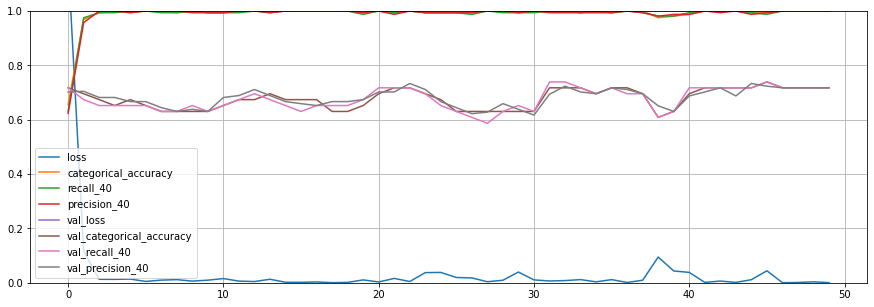

In [ ]:
Mixure_Model = keras.Sequential([
    MLPMixerLayer(num_patches, embedding_dim, dropout_rate),
    FNetLayer(num_patches, embedding_dim, dropout_rate),
    gMLPLayer(num_patches, embedding_dim, dropout_rate)
])
learning_rate = 0.001
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)

## Mixture 2

Epoch 1/50
5/5 [==============================] - 5s 512ms/step - loss: 0.3172 - categorical_accuracy: 0.8875 - recall_39: 0.8500 - precision_39: 0.8608 - val_loss: 1.5545 - val_categorical_accuracy: 0.7826 - val_recall_39: 0.7609 - val_precision_39: 0.7292
Epoch 2/50
5/5 [==============================] - 0s 96ms/step - loss: 0.1100 - categorical_accuracy: 0.9625 - recall_39: 0.9625 - precision_39: 0.9625 - val_loss: 1.9408 - val_categorical_accuracy: 0.7391 - val_recall_39: 0.7391 - val_precision_39: 0.6800
Epoch 3/50
5/5 [==============================] - 0s 99ms/step - loss: 0.0789 - categorical_accuracy: 0.9500 - recall_39: 0.9625 - precision_39: 0.9565 - val_loss: 2.1468 - val_categorical_accuracy: 0.6957 - val_recall_39: 0.6957 - val_precision_39: 0.6957
Epoch 4/50
5/5 [==============================] - 0s 96ms/step - loss: 0.0491 - categorical_accuracy: 0.9875 - recall_39: 0.9812 - precision_39: 0.9874 - val_loss: 2.4681 - val_categorical_accuracy: 0.6739 - val_recall_39: 0.717

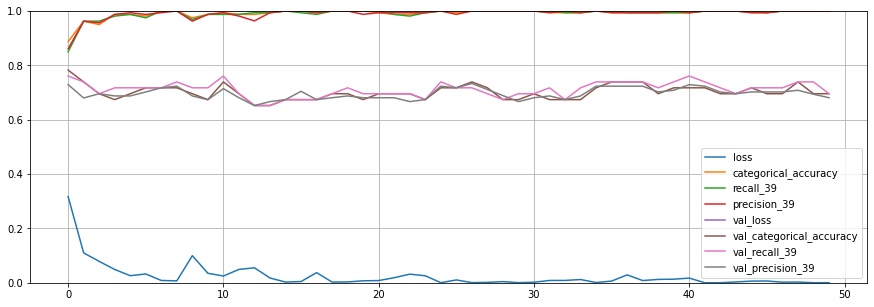

In [ ]:
Mixure_Model = keras.Sequential([
    MLPMixerLayer(num_patches, embedding_dim, dropout_rate),
    FNetLayer(num_patches, embedding_dim, dropout_rate),
    gMLPLayer(num_patches, embedding_dim, dropout_rate)
])
learning_rate = 0.001
mlpmixer_classifier = build_classifier(mlpmixer_blocks,positional_encoding=True)
history = run_experiment(mlpmixer_classifier)

# Mixture 3

Epoch 1/50
5/5 [==============================] - 4s 333ms/step - loss: 0.4840 - categorical_accuracy: 0.9125 - recall_31: 0.7750 - precision_31: 0.8552 - val_loss: 3.0644 - val_categorical_accuracy: 0.7174 - val_recall_31: 0.6957 - val_precision_31: 0.6957
Epoch 2/50
5/5 [==============================] - 0s 88ms/step - loss: 0.4337 - categorical_accuracy: 0.9062 - recall_31: 0.9187 - precision_31: 0.8750 - val_loss: 3.1219 - val_categorical_accuracy: 0.7174 - val_recall_31: 0.6304 - val_precision_31: 0.7436
Epoch 3/50
5/5 [==============================] - 0s 94ms/step - loss: 0.3028 - categorical_accuracy: 0.9312 - recall_31: 0.9125 - precision_31: 0.9012 - val_loss: 3.6006 - val_categorical_accuracy: 0.7391 - val_recall_31: 0.7826 - val_precision_31: 0.6792
Epoch 4/50
5/5 [==============================] - 0s 95ms/step - loss: 0.2939 - categorical_accuracy: 0.8938 - recall_31: 0.8938 - precision_31: 0.9108 - val_loss: 3.5201 - val_categorical_accuracy: 0.6739 - val_recall_31: 0.652

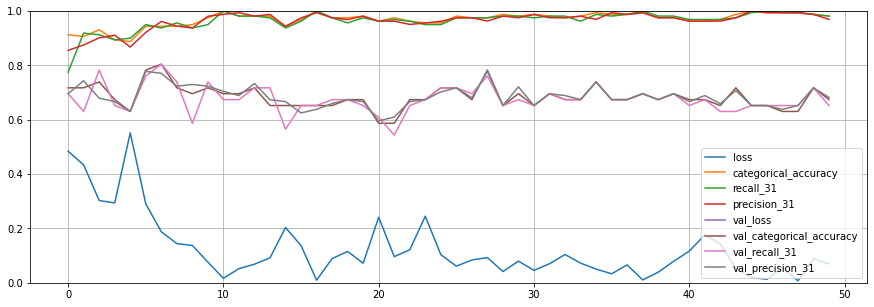

In [ ]:
Mixure_Model = keras.Sequential([
    MLPMixerLayer(num_patches, embedding_dim, dropout_rate),
    MLPMixerLayer(num_patches, embedding_dim, dropout_rate),
    FNetLayer(num_patches, embedding_dim, dropout_rate),
    FNetLayer(num_patches, embedding_dim, dropout_rate),
    gMLPLayer(num_patches, embedding_dim, dropout_rate),
    gMLPLayer(num_patches, embedding_dim, dropout_rate)
])
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)

## Mixture 4

Epoch 1/50
5/5 [==============================] - 5s 339ms/step - loss: 0.8298 - categorical_accuracy: 0.7563 - recall_32: 0.7563 - precision_32: 0.7289 - val_loss: 2.9183 - val_categorical_accuracy: 0.6304 - val_recall_32: 0.5435 - val_precision_32: 0.6579
Epoch 2/50
5/5 [==============================] - 0s 94ms/step - loss: 0.4478 - categorical_accuracy: 0.9250 - recall_32: 0.9187 - precision_32: 0.9130 - val_loss: 4.0716 - val_categorical_accuracy: 0.7174 - val_recall_32: 0.7609 - val_precision_32: 0.6863
Epoch 3/50
5/5 [==============================] - 0s 88ms/step - loss: 0.3871 - categorical_accuracy: 0.9125 - recall_32: 0.9250 - precision_32: 0.9136 - val_loss: 5.2429 - val_categorical_accuracy: 0.6522 - val_recall_32: 0.6304 - val_precision_32: 0.6444
Epoch 4/50
5/5 [==============================] - 0s 95ms/step - loss: 0.2961 - categorical_accuracy: 0.9438 - recall_32: 0.9250 - precision_32: 0.9367 - val_loss: 6.7982 - val_categorical_accuracy: 0.6087 - val_recall_32: 0.608

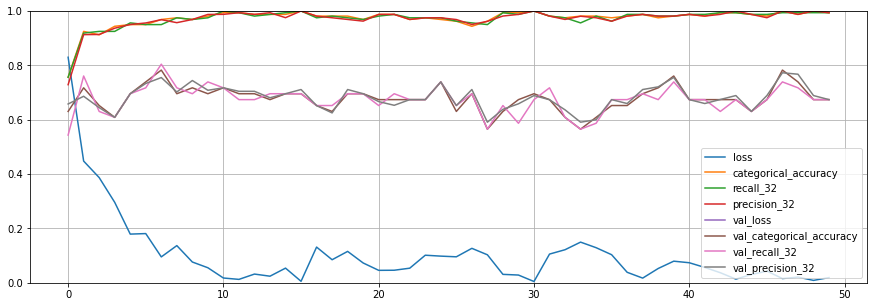

In [ ]:
Mixure_Model = keras.Sequential([
    MLPMixerLayer(num_patches, embedding_dim, dropout_rate),
    MLPMixerLayer(num_patches, embedding_dim, dropout_rate),
    FNetLayer(num_patches, embedding_dim, dropout_rate),
    FNetLayer(num_patches, embedding_dim, dropout_rate),
    gMLPLayer(num_patches, embedding_dim, dropout_rate),
    gMLPLayer(num_patches, embedding_dim, dropout_rate)
])
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks,positional_encoding=True)
history = run_experiment(mlpmixer_classifier)

## Mixture 5

Epoch 1/50
5/5 [==============================] - 4s 322ms/step - loss: 0.5405 - categorical_accuracy: 0.9250 - recall_36: 0.8562 - precision_36: 0.8562 - val_loss: 2.9336 - val_categorical_accuracy: 0.7174 - val_recall_36: 0.6522 - val_precision_36: 0.7317
Epoch 2/50
5/5 [==============================] - 0s 91ms/step - loss: 0.0931 - categorical_accuracy: 0.9875 - recall_36: 0.9750 - precision_36: 0.9571 - val_loss: 5.2479 - val_categorical_accuracy: 0.6739 - val_recall_36: 0.6957 - val_precision_36: 0.6809
Epoch 3/50
5/5 [==============================] - 0s 91ms/step - loss: 0.1493 - categorical_accuracy: 0.9812 - recall_36: 0.9812 - precision_36: 0.9752 - val_loss: 5.8455 - val_categorical_accuracy: 0.6522 - val_recall_36: 0.6522 - val_precision_36: 0.6818
Epoch 4/50
5/5 [==============================] - 0s 94ms/step - loss: 0.1732 - categorical_accuracy: 0.9750 - recall_36: 0.9625 - precision_36: 0.9625 - val_loss: 4.9856 - val_categorical_accuracy: 0.6087 - val_recall_36: 0.630

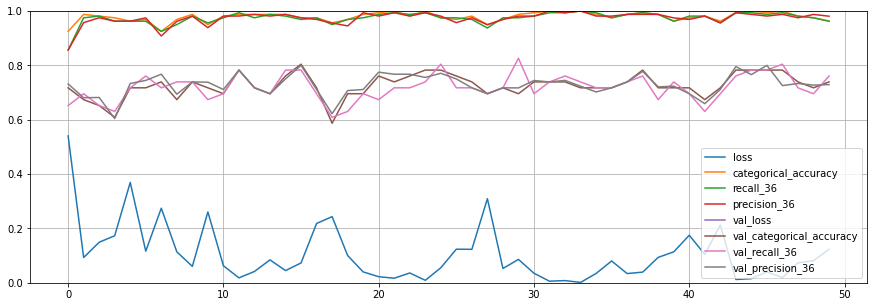

In [ ]:
Mixure_Model = keras.Sequential([
    FNetLayer(num_patches, embedding_dim, dropout_rate),
    keras.layers.Dropout(0.2),
    MLPMixerLayer(num_patches, embedding_dim, dropout_rate),
    FNetLayer(num_patches, embedding_dim, dropout_rate),
    keras.layers.Dropout(0.2),
    MLPMixerLayer(num_patches, embedding_dim, dropout_rate),
    FNetLayer(num_patches, embedding_dim, dropout_rate),
    keras.layers.Dropout(0.2),
    gMLPLayer(num_patches, embedding_dim, dropout_rate),
    FNetLayer(num_patches, embedding_dim, dropout_rate),
    keras.layers.Dropout(0.2),
    gMLPLayer(num_patches, embedding_dim, dropout_rate),
    FNetLayer(num_patches, embedding_dim, dropout_rate),
])
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks,positional_encoding=True)
history = run_experiment(mlpmixer_classifier)